## Import e init

importiamo le librerie necessarie e inizializziamo la lettura del documento SVG

In [1]:
from xml.dom import minidom

import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch
import re
import math
import numpy as np

from shapely.geometry import Point, Polygon

from blueprint import *

In [2]:
doc = minidom.parse('drawing.svg')

## Data process

Leggiamo alcune proprietà del file:

In [3]:
dimensions = doc.getElementsByTagName('svg')[0].getAttribute('viewBox').split()
dimensions = [float(i) for i in dimensions]

BP = Blueprint(dimensions[0],dimensions[1],dimensions[2],dimensions[3])

try:
    gTranslation = doc.getElementsByTagName('g')[0].getAttribute('transform')
    gTranslation = re.search('translate\(([^\)]+)\)',gTranslation).group(1).split(',')
    xTranslation = float(gTranslation[0])
    yTranslation = float(gTranslation[1])
except:
    xTranslation = 0.0
    yTranslation = 0.0
    
BP.setTranslation(xTranslation,yTranslation)

Troviamo le uscite e le entrate. L'entrata è determinata dall'id **entrata**\_n e l'uscita da **uscita**\_n

In [4]:
entrances = {}
exits  = {}

for path in doc.getElementsByTagName('path'):
    idPath = path.getAttribute('id')
    if idPath.startswith( 'entrata' ):
        ref = entrances[idPath] = {}
    elif idPath.startswith( 'uscita' ):
        ref = exits[idPath]  = {}
    else:
        continue
    
    ref['object'] = path
    ref['cx'] = float(path.getAttribute('sodipodi:cx'))
    ref['cy'] = float(path.getAttribute('sodipodi:cy'))

Troviamo ora i muri. Tutti i muri sono i rect

In [5]:
walls = []

for rect in doc.getElementsByTagName('rect'):
    idRect = rect.getAttribute('id')

    x = float(rect.getAttribute('x'))
    y = float(rect.getAttribute('y'))
    width = float(rect.getAttribute('width'))
    height = float(rect.getAttribute('height'))
    
    matrixTransformation = False
    scaleTransformation  = False
    if rect.hasAttribute('transform'):
        m = re.search('matrix\(([^\)]+)\)', rect.getAttribute('transform'))
        if m:
            matrixTransformation = m.group(1).split(',')
        s = re.search('scale\(([^\)]+)\)', rect.getAttribute('transform'))
        if s:
            scaleTransformation = s.group(1).split(',')
    
    wall = Wall(x,y,width,height,matrixTransformation,scaleTransformation)
    wall.setID(idRect)
    
    walls.append(wall)

Ed infine, più o meno nello stesso modo, troviamo i punti di attrazione (circle):

In [6]:
attractionPoints = []

for circle in doc.getElementsByTagName('circle'):
    idCircle = circle.getAttribute('id')

    x = float(circle.getAttribute('cx'))
    y = float(circle.getAttribute('cy'))
    r = float(circle.getAttribute('r'))
    
    circle = attractionPoint(x,y,r)
    circle.setID(idCircle)
    
    attractionPoints.append(circle)

## Init sniffing paths
Per ogni attraction point ci deve essere una pollicinata per arrivarci, altrimenti il walker sarà attratto attraverso i muri

In [7]:
BP.setCellDimension(15)
BP.defineMaze(walls)

In [8]:
# colletting uniformed points
points = {}

for entranceID,entrance in entrances.items():
    points[entranceID] = entrance
for exitID,exit in exits.items():
    points[exitID] = exit
for ap in attractionPoints:
    points[ap.id] = {'object':ap,'cx':ap.cx,'cy':ap.cy}

In [9]:
for idFrag,point in points.items():
    BP.calcFragrance(point,idFrag)

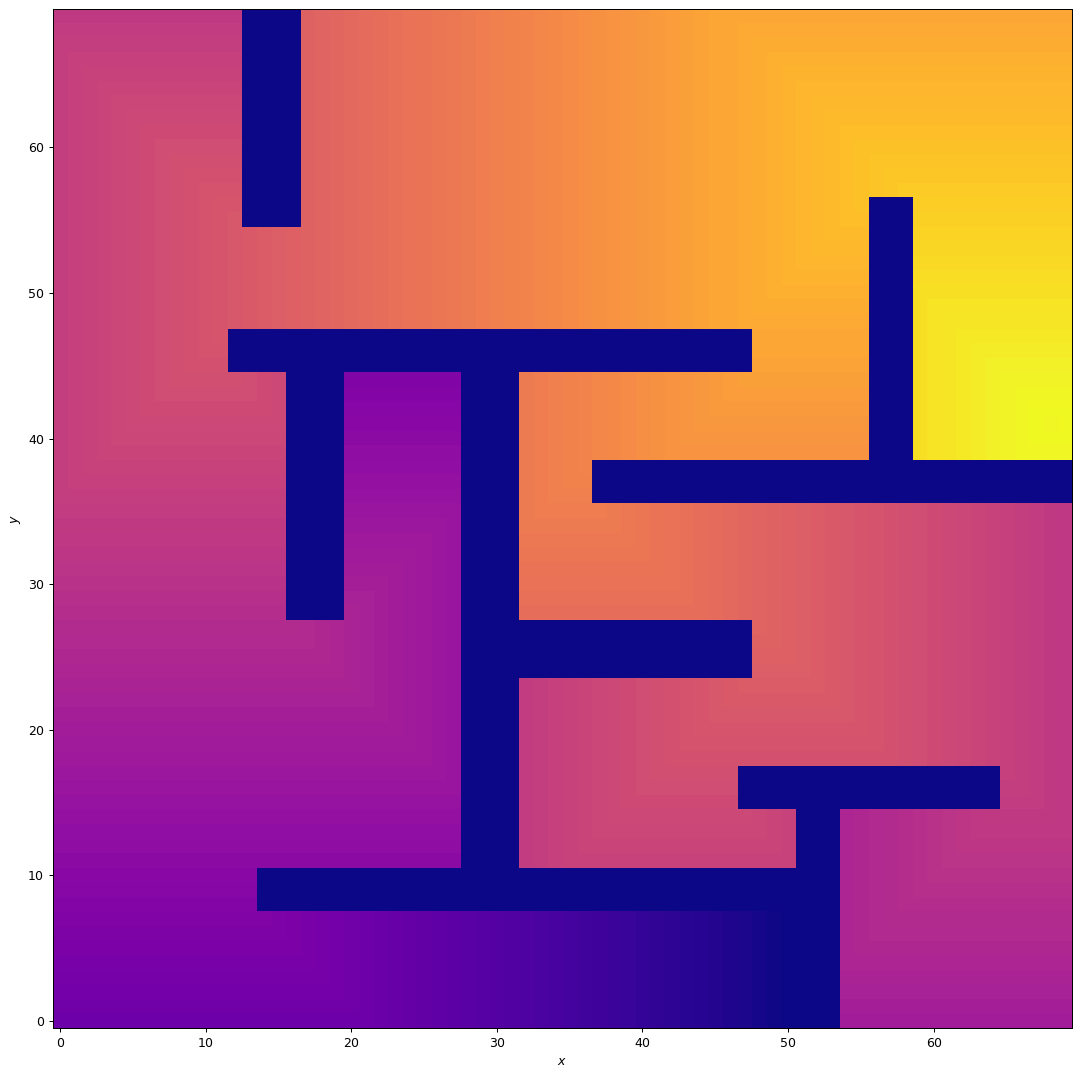

In [19]:
plotMaze(BP.fragrances['uscita'].sniffingMap)

# Walking

In [10]:
points.keys()

dict_keys(['entrata', 'uscita', 'AP1', 'AP1-2', 'AP1-2-2', 'AP1-2-8', 'AP1-2-0'])

In [11]:
BP.addWalker(points['entrata'],['AP1','AP1-2-2','AP1-2-8','uscita'],'pietro')

In [12]:
BP.walkers['pietro']

In [13]:
BP.walkers['pietro'].startWalking()

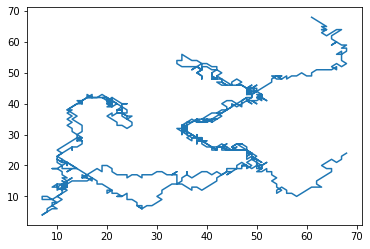

In [15]:
plt.plot(*zip(*BP.walkers['pietro'].pathway))

In [16]:
def plotWalkerPathway(maze,walker,title=None):
    a = np.copy(maze)

    print(a.shape)
    for i, (x, y) in enumerate(walker.pathway):
        a[x][y] = 2

    figure = plt.figure(figsize=[15, 15], dpi=90)

    plt.imshow(np.rot90(a), cmap='plasma', interpolation='nearest')
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.gca().invert_yaxis()

    plt.show()

(70, 70)


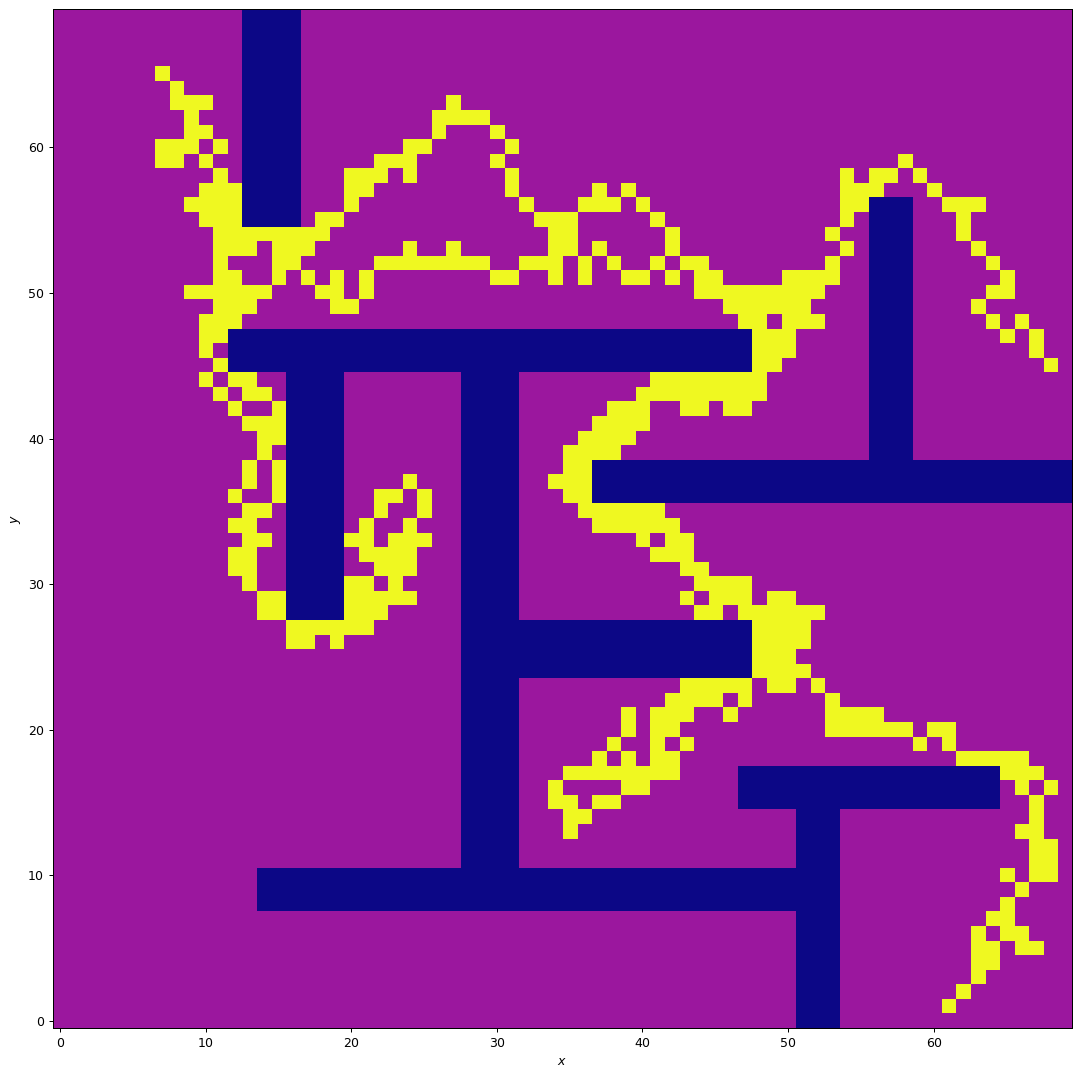

In [21]:
plotWalkerPathway(BP.maze,BP.walkers['pietro'])